### 逻辑回归算法代码实现

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib import rcParams  # rcParams是Matplotlib中的一个字典，用于管理默认参数和属性
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score

In [2]:
config = {
    "mathtext.fontset": 'stix',  # 数学公式的字体集
    "font.family": 'serif',  # 指定绘图中的字体系列为衬线字体
    "font.serif": ['SimHei'],  # 设置衬线字体的具体类型，中文宋体
    "font.size": 10,  # 字号，大家自行调节
    'axes.unicode_minus': False  # 处理负号，即-号
}
rcParams.update(config)  # 设置画图的一些参数

In [3]:
path = r'C:\Users\yz\Desktop\机器学习\ex2data1.csv'
data = pd.read_csv(path)  # data 是dataframe 的数据类型
data.head()  # 返回data中的前几行数据，默认是前5行。

,34.62365962451697,78.0246928153624,0
0,30.286711,43.894998,0
1,35.847409,72.902198,0
2,60.182599,86.308552,1
3,79.032736,75.344376,1
4,45.083277,56.316372,0


In [4]:
# 特征与标签提取
cols = data.shape[1]  # data.shape 返回一个元组，元组的第一个元素表示数据集的行数，第二个元素表示数据集的列数
X_data = data.iloc[:, :cols - 1]  # X去掉最后一列
Y_data = data.iloc[:, cols - 1:]  # Y 最后一列

x_data = X_data.values
y_data = Y_data.values

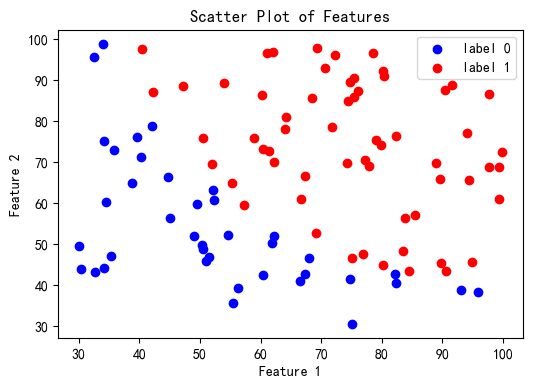

In [5]:
# 绘制数据二维散点图
plt.figure(figsize=(6, 4))
plt.scatter(x_data[y_data[:, 0] == 0][:, 0], x_data[y_data[:, 0] == 0][:, 1], c='blue', marker='o', label='label 0')
plt.scatter(x_data[y_data[:, 0] == 1][:, 0], x_data[y_data[:, 0] == 1][:, 1], c='red', marker='o', label='label 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Features')
plt.legend()
plt.show()

#### 回归模型相关函数

In [6]:

# 建立逻辑回归模型 ， 使用sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
#定义损失函数
def computeCost(X, Y, W):
    P = sigmoid(np.dot(X, W))
    loss = np.sum(-Y * np.log(P) - (1 - Y) * np.log(1 - P)) / len(Y)
    return loss, P

In [8]:
alpha = 0.0001
iters = 10000

In [9]:
# 计算损失函数对w参数的导数
def gradientDecent(W, X, Y):
    error = sigmoid(np.dot(X, W)) - Y
    grad = np.dot(X.T, error) / X.shape[1]
    W -= alpha * grad
    return W

In [10]:
# 逻辑回归参数训练过程
def logisticRegression(X, Y, alpha, iters):
    loss_his = []  # 初始化模型参数
    W_his = []
    feature_dim = X.shape[1]
    W = np.zeros((feature_dim, 1))  # 初始化W系数矩阵，w 是一个(feature_dim,1)矩阵
    # 重复步骤2和步骤3，直到收敛或迭代结束
    for i in range(iters):
        # step2 : 使用初始化参数预测输出并计算损失
        loss, P = computeCost(X, Y, W)
        loss_his.append(loss)
        # step3: 采用梯度下降法更新参数
        W_his.append(W.copy())  # 记录W
        W = gradientDecent(W, X, Y)

    return loss_his, W, W_his  # 返回损失和模型参数。

In [11]:
# 数据归一化
def normalize_data(data):
    normalized_data = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))  # axis=0沿着每列
    return normalized_data  # , np.min(data, axis=0), np.max(data, axis=0)


x_data = normalize_data(x_data)


#### 数据划分

In [12]:
# 准备
train_losses = []
test_losses = []
W_train_his = []

precision_his = []
recall_his = []
f1_his = []
fpr_his = []
tpr_his = []
roc_auc_his = []

In [13]:
# 数据划分——K折交叉验证

# 初始化5折交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(x_data, y_data):
    # 划分训练集和验证集
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    # 训练逻辑回归模型
    train_loss_history, W_train, W_his = logisticRegression(x_train, y_train, alpha, iters)
    W_train_his.append(W_train)

    # 在测试集上计算损失
    test_loss_history = []
    for W in W_his:
        loss, _ = computeCost(x_test, y_test, W)
        test_loss_history.append(loss)

    train_losses.append(train_loss_history)
    test_losses.append(test_loss_history)

    # 计算测试集上的预测
    test_predictions = sigmoid(np.dot(x_test, W_train))
    # 将概率进行阈值处理，得到二元预测结果
    binary_predictions = (test_predictions >= 0.5).astype(int)


    # 计算评估指标
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    f1 = f1_score(y_test, binary_predictions)
    fpr, tpr, _ = roc_curve(y_test, test_predictions)
    # roc_auc = auc()

    precision_his.append(precision)
    recall_his.append(recall)
    f1_his.append(f1)
    fpr_his.append(fpr)
    tpr_his.append(tpr)

In [14]:
# 计算每次迭代的平均训练损失和测试损失
avg_train_loss = np.mean(train_losses, axis=0)
avg_test_loss = np.mean(test_losses, axis=0)
W_train_his_avg = np.mean(W_train_his, axis=0)

# 计算评估指标的平均值
precision_avg = np.mean(precision_his)
recall_avg = np.mean(recall_his)
f1_avg = np.mean(f1_his)
fpr_grid = np.linspace(0.0, 1.0, 100)
mean_tpr = np.zeros_like(fpr_grid)
for i in range(5):
    mean_tpr += np.interp(fpr_grid, fpr_his[i], tpr_his[i])
fpr_grid = np.insert(fpr_grid, 0, 0.0)
mean_tpr = np.insert(mean_tpr, 0, 0.0)
mean_tpr = mean_tpr/5

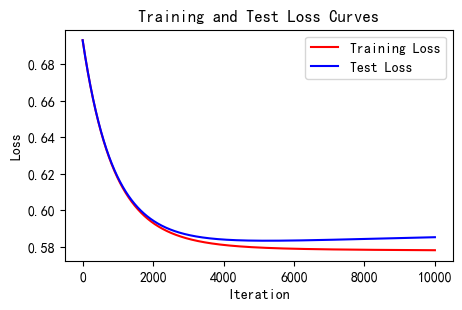

In [15]:
# 画出训练和测试的损失曲线
plt.figure(figsize=(5, 3))
plt.plot(np.arange(iters), avg_train_loss, c='r', label='Training Loss')
plt.plot(np.arange(iters), avg_test_loss, c='b', label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()

#### 画出ROC曲线

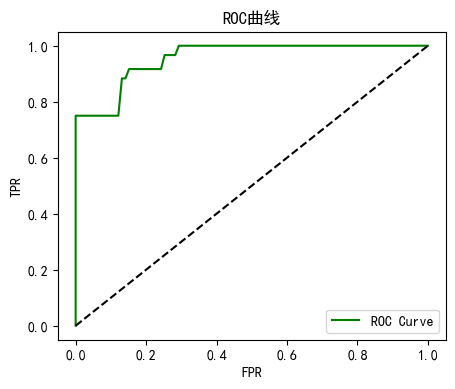

In [16]:
plt.figure(figsize=(5, 4))
plt.plot(fpr_grid, mean_tpr, color='g', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC曲线')
plt.legend(loc='lower right')
plt.show()

#### 给出评价指标

In [17]:
roc_auc = auc(fpr_grid, mean_tpr)

print("roc_auc:",roc_auc)
print("precision_avg:",precision_avg)
print("recall:",recall_avg)
print("F1-score:",f1_avg)

roc_auc: 0.9563131313131313
precision_avg: 0.6063157894736841
recall: 1.0
F1-score: 0.7548387096774192
